# Create a NARR probability distribution for 3 hourly windspeeds
 1) Find the coordinates of each sediment flux site<br>
 2) Find the NARR gridcell that is closest to the flux coordinates<br>
 3) Compute the wind probability distribution at that site for each date we have a measurement

In [1]:
"""narr_wind_pdf.ipynb 
    
    Create a NARR probability distribution for 3 hourly windspeeds. 
    This notebook relies on uwnd and vwnd variables from NOAA's NARR windspeeds at 10m height (uwnd.10m, vwnd.10m)
    Make sure you add coordinates for any new sites to the csv file site_locations.csv
    
    Author: Nicole Keeney
    Created: 01/21/2022
    Modification History: n/a
    
"""

import os 
import sys 
from tqdm import tqdm # Progress bar 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd 
import numpy as np 
from scipy import stats
import warnings
from pyproj import Transformer

sys.path.append('..')
from utils.read_data_utils import read_datetime_csv

In [2]:
# --------------- USER INPUTS ---------------

# List of sites to compute wind PDF for 
# If you just want to compute it for one site, make sure it's in a list; i.e. ["NEAT1"]
site_list = ["Moab","Pullman","Holloman","Mandan","SanLuisValley","NEAT1","NEAT2","NEAT3"]

# Directory containing wind and flux data for each site 
data_dir = "../data/site_data/"

# Wind bins to use for computing PDF 
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,1000]

In [3]:
# --------------- READ IN NARR RASTERS ---------------
# The data used is the 10m u and v windspeeds from the NARR reanalysis 

uwnd_paths, vwnd_paths = [],[]
for year in np.arange(2009,2021,1): # Date range for which we have flux measurements 
    u_path = data_dir+"narr_wind/uwnd/uwnd.10m."+str(year)+".nc" # Path to u data for that year
    v_path = data_dir+"narr_wind/vwnd/vwnd.10m."+str(year)+".nc" # Path to v data for that year
    if os.path.exists(u_path):
        uwnd_paths.append(u_path)
    else: 
        print("No u wind file found for year {year}".format(year=year)) # Print warning if no file found for that year
    if os.path.exists(v_path): 
        vwnd_paths.append(v_path)
    else: 
        print("No v wind file found for year {year}".format(year=year)) # Print warning if no file found for that year
        
# Read in list of filenames 
with warnings.catch_warnings(record=True): # Hide annoying warnings 
    u = xr.open_mfdataset(uwnd_paths, decode_coords="all").uwnd
    v = xr.open_mfdataset(vwnd_paths, decode_coords="all").vwnd

  0%|                                                     | 0/8 [00:00<?, ?it/s]

Computing wind PDF for Moab...
Collection site coordinates: (38.651, -109.87)
Closest NARR gridcell coordinate: (38.62, -109.756)
complete


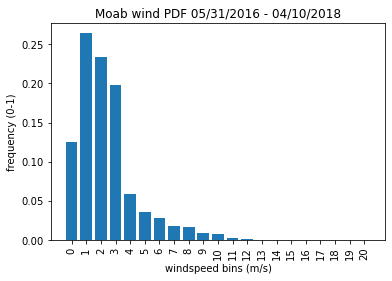

 12%|█████▌                                      | 1/8 [02:18<16:06, 138.03s/it]

Computing wind PDF for Pullman...
Collection site coordinates: (46.887, -118.285)
Closest NARR gridcell coordinate: (46.761, -118.324)
complete


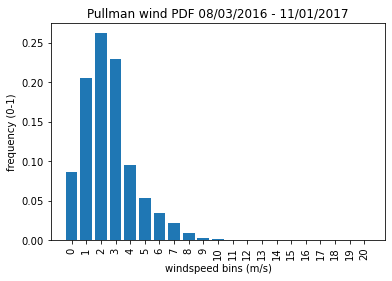

 25%|███████████                                 | 2/8 [04:34<13:41, 136.97s/it]

Computing wind PDF for Holloman...
Collection site coordinates: (32.942, -106.107)


In [ ]:
# Read in csv with lat/lon coords of each site 
site_locations = pd.read_csv("../data/site_data/site_locations.csv", index_col="Site")

for site_name in tqdm(site_list): 
    print("Computing wind PDF for {site_name}...".format(site_name=site_name))
    
    # ------------------ GET CLOSEST NARR GRIDCELL ------------------

    # First, we get the coordinates of each collection site. 
    # Then, using information from the NARR file, we can construct a proj string defining the native grid of the data (Lambert Conformal Conic). 
    # Then, we convert the collection site's coordinates from lat/lon to the projection coordinates of the NARR rasters using the Proj library. 
    # Lastly, we use the projected coornates to find the NARR gridcell that is closest to each collection site using xarray vectorized indexing 
    # Vectorized indexing: https://xarray.pydata.org/en/stable/user-guide/indexing.html#vectorized-indexing)

    # Get lat/lon coords of site 
    site_coords = site_locations.loc[site_name]
    lat, lon = site_coords.Latitude, site_coords.Longitude
    print("Collection site coordinates: ({lat}, {lon})".format(lat=round(lat,3), lon=round(lon,3)))

    # Transform coordinates to Lambert Conformal Conic 
    # https://proj.org/operations/projections/lcc.html#:~:text=A%20Lambert%20Conformal%20Conic%20projection,Johann%20Heinrich%20Lambert%20in%201772.
    proj_attrs = u.Lambert_Conformal.attrs
    proj_string = "+proj=lcc +lat_0={lat_origin} +lon_0={lon_origin} +lat_1={first_par} +lat_2={second_par} +x_0={fal_east} +y_0={fal_north}\
                    ".format(lat_origin=proj_attrs["latitude_of_projection_origin"], lon_origin=proj_attrs["longitude_of_central_meridian"], 
                             first_par=proj_attrs["standard_parallel"][0], second_par=proj_attrs["standard_parallel"][1],
                             fal_east=proj_attrs["false_easting"], fal_north=proj_attrs["false_northing"])
    transformer = Transformer.from_crs("epsg:4326", proj_string, always_xy=False)
    x, y = transformer.transform(lat, lon)

    # Get closest gridcell 
    site_u = u.sel(x=x, y=y, method="nearest").load()
    site_v = v.sel(x=x, y=y, method="nearest").load()
    print("Closest NARR gridcell coordinate: ({lat}, {lon})".format(lat=round(site_u.lat.item(),3), lon=round(site_u.lon.item(),3)))


    # ------------------ COMPUTE WIND PDF FOR EACH MEASUREMENT DATE ------------------

    # Read in data for that site
    flux_data = read_datetime_csv(path = data_dir+site_name+"/field_Q/"+site_name+"_fieldQ.csv") # Sediment flux measurements
    measurement_dates = list(flux_data.index) # Measurement dates 

    if "NEAT" in site_name: 
        first_date = pd.to_datetime("2008-04-01") # Date lost during computation of Q from sediment weights 
        measurement_dates = [first_date] + measurement_dates

    # Loop through each measurement date, excluding the final date 
    wind_pdf_all = [] # Append PDF for each date here 
    for i in range(len(measurement_dates)-1): 

        # Get range of dates that occur around 
        start_date = measurement_dates[i] 
        end_date = measurement_dates[i+1]

        # Get NARR data between those dates 
        u_masked = site_u.sel(time=slice(start_date,end_date)).values
        v_masked = site_v.sel(time=slice(start_date,end_date)).values

        # Compute windspeed = sqrt(u^2+v^2)
        windspeed = np.sqrt(u_masked**2+v_masked**2)

        # Compute the PDF on the bin centers from scipy distribution object
        counts_number, bin_edges = np.histogram(windspeed, bins=bins)
        rel_freq = counts_number/len(windspeed)
        wind_pdf_i = pd.Series(data=rel_freq, index=bins[:-1])
        wind_pdf_i.index.name = "bins"

        # Append to list 
        wind_pdf_all.append(wind_pdf_i)

    # Combine to form one dataframe 
    pdf_df = pd.DataFrame(data=wind_pdf_all, index=measurement_dates[1:]) # Skip first day
    pdf_df.index.name = "Date"

    # Save csv 
    output_filename = site_name + "_NARR_wind_pdf.csv"
    pdf_df.to_csv(data_dir+site_name+"/wind/"+output_filename, index=True) 
    print("complete")


    # ------------------ COMPUTE WIND PDF FOR ENTIRE PERIOD ------------------

    start_date = measurement_dates[0]
    end_date = measurement_dates[-1]
    u_masked = site_u.sel(time=slice(start_date, end_date)).values
    v_masked = site_v.sel(time=slice(start_date, end_date)).values
    windspeed = np.sqrt(u_masked**2+v_masked**2)

    # Compute the PDF on the bin centers from scipy distribution object
    counts_number, bin_edges = np.histogram(windspeed, bins=bins)
    rel_freq = counts_number/len(windspeed)

    # Generate figure
    title = site_name+" wind PDF "+start_date.strftime("%m/%d/%Y")+" - "+end_date.strftime("%m/%d/%Y")
    figname = "narr_wind_pdf_"+site_name+".png"
    plt.bar(bins[:-1], rel_freq)
    plt.title(title)
    plt.xlabel(xlabel="windspeed bins (m/s)")
    plt.ylabel(ylabel="frequency (0-1)")
    plt.xticks(bins[:-1], rotation=90)
    #plt.grid(alpha=0.5, linestyle='--')
    plt.savefig(data_dir+site_name+"/wind/"+figname, dpi=300, facecolor="white")
    plt.show()